# Machine Learning Competition - code

### By Angel Morales and David Gonzalez.

# Introduction

This contains the entire code used for the "Machine Learning Competition". It contains:

0. Initial configuration
1. Descriptive statistics
2. Data pre-processing
3. Decision making
4. Model training
5. Test prediction making

# 0. Initial configuration

Imports and definition of constants and auxiliar functions

In [1]:
# Recommended Python version: 3.12.6

# Uncomment to install / update packages:

#!pip install -U numpy
#!pip install -U pandas
#!pip install -U matplotlib
#!pip install -U seaborn
#!pip install -U scikit-learn
#!pip install -U imblearn

## Imports

In [2]:
# Data treatment and operations

import itertools
import numpy as np
import pandas as pd
from scipy import stats

# Data visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from imblearn.over_sampling import SMOTE, ADASYN

# Models

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, precision_score, classification_report, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV, StratifiedKFold, cross_val_score

## Linear classification

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

## SVM

from sklearn.svm import SVC

## Ensembles

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, StackingClassifier, AdaBoostClassifier

## Seed to allow replication

In [3]:
np.random.seed(55182183)

## Auxiliar functions

In [4]:
def confusion(true, pred):
    """
    Function for pretty printing confusion matrices
    """
    pred = pd.Series(pred)
    true = pd.Series(true)
    
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm


def specificity_score(y_true, y_pred):
    """
    Calculate the specificity given 2 vectors: prediction vs actual labels
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)


def metrics_dict(y_actual, y_pred) -> dict[str, float]:
    """
    Compute and return the general metrics: F-score, specificity, accuracy, precision and recall.
    """
    return {
        'F-score': f1_score(y_actual, y_pred, zero_division=0),
        'Specificity': specificity_score(y_actual, y_pred),
        'Accuracy': accuracy_score(y_actual, y_pred),
        'Precision': precision_score(y_actual, y_pred, zero_division=0),
        'Recall': recall_score(y_actual, y_pred, zero_division=0)
    } # type: ignore


def evaluate_on_holdout(model, X_train, y_train, X_test, y_test):
    """
    Train the model and test it. Return the metrics_dict on the test.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return metrics_dict(y_test, y_pred)

# 1. Descriptive statistics and online research

This section also contains a prior study on the field, by searching for information on the internet.

We have checked:
- Dataset's structure
- Each variable's histogram
- Pairplots to visually check correlations

We have done some research online to have a prior knowledge on how the variables are related to liver-patients. First, we will talk about general findings and sources, and then we will specifically analyse every variable.

The given variables are similar to the ones used in a liver profile. We can get some stadard ranges for all the variables and critical thresholds. Some of the sources contain values for different varaibles.

This allows to detect outliers and better understand of the algorithms are properly predicting.

Sources:

https://www.topdoctors.es/diccionario-medico/perfil-hepatico/
https://www.sanitas.es/biblioteca-de-salud/enfermedades-y-trastornos/endocrinas/perfil-hepatico
https://www.testing.com/tests/liver-panel/

In [5]:
# Dataset creation and check

ATTRIBUTE_NAMES = ['age', 'female', 'tb', 'db', 'alkphos', 'sgpt', 'sgot', 'tp', 'alb', 'a/r']

X = pd.read_csv('train_features_ILDS.csv', header=None, names=ATTRIBUTE_NAMES, dtype='float') # type: ignore
# We will keep 'female' as a float for now.

y = pd.read_csv('train_labels_ILDS.csv', header=None, names=['label'], dtype='int') # type: ignore
y = y['label']

print(X.shape) # 463 x 10, as expected
print(y.shape) # 463 x  1, as expected

print(X.head()) # First rows correctly printed
print(y.head()) # Correct

(463, 10)
(463,)
    age  female   tb   db  alkphos   sgpt    sgot   tp  alb   a/r
0  40.0     0.0  3.9  1.7    350.0  950.0  1500.0  6.7  3.8  1.30
1  48.0     0.0  4.5  2.3    282.0   13.0    74.0  7.0  2.4  0.52
2  39.0     0.0  1.9  0.9    180.0   42.0    62.0  7.4  4.3  1.38
3  23.0     0.0  1.0  0.3    212.0   41.0    80.0  6.2  3.1  1.00
4  42.0     1.0  0.7  0.2    152.0   35.0    81.0  6.2  3.2  1.06
0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64


## Variable by variable analysis

We will use 2 characteristic colors for the labels:

- Red indicates liver patients.
- Green indicates non-liver patients (healthy).

Some of the auxiliar functions that we will use:

The **expo_range** function generates n values between start_val and end_val, spaced exponentially. For example, calling expo_range(0.25, 8, 6) returns [0.25, 0.5, 1, 2, 4, 8]. This is useful for selecting a wide and well-distributed range of hyperparameter values during tuning.

The **submit** function takes a list y_pred and saves it as a CSV file in the format required for Kaggle submission.

In [6]:
# Auxiliar code

custom_palette = {0: "red", 1: "green"}


def plot_histogram(variable: str, X, y):
    """
    Plot the histogram of the given variable in the dataset X, using the labels of y for colors.
    Assumes that X contains the variable and y contains only a column label with 0s and 1s.
    """
    plt.figure(figsize=(7, 5))
    sns.histplot(x=variable, hue=y, data=X, multiple='stack', palette=custom_palette)
    plt.title(variable)
    plt.tight_layout()
    plt.show()


def shapiro_test(variable: str, X):
    """
    Performs and displays the result of the Shapiro test for normality on the given variable of the dataset X.
    """
    stat, p_value = stats.shapiro(X[variable])
    print(f"\nShapiro-Wilk test result for normality:\nStatistic: {stat:.4f}, p-value: {p_value:.4f}")
    if p_value > 0.05:
        print("The data appears to be normally distributed (fail to reject H0).")
    else:
        print("The data does not appear to be normally distributed (reject H0).")


def expo_range(start_val, end_val, n):
    """
    Generates an array of n values exponencially spaced between 'start_val' and 'end_val'. The values follow a geometric progression. 
    Example: expo_range(0.1, 10, 3) -> [0.1, 1.0, 10.0]
    """

    logs = np.linspace(np.log10(start_val), np.log10(end_val), n)
    return list(np.round(10 ** logs, decimals=10))


def submit(y_pred, filename="submission.csv"):
    """
    Takes a vector of predictions 'y_pred' and generates a CSV file prepared to be sent to Kaggle
    """
    submission = pd.DataFrame({
        'ID': np.arange(1, len(y_pred) + 1),
        'Label': y_pred
    })
    submission.to_csv(filename, index=False)
    print(f"Predictions saved in '{filename}'")

The variables for this dataset are:

1. Age: Age of the patient
2. Female: Gender of the patient (1 if Female, 0 if Male)
3. TB: Total Bilirubin
4. DB: Direct Bilirubin
5. Alkphos: Alkaline Phosphotase
6. Sgpt: Alanine Aminotransferase
7. Sgot: Aspartate Aminotransferase
8. TP: Total Protiens
9. ALB: Albumin
10. A/R: Albumin and Globulin Ratio

### Age

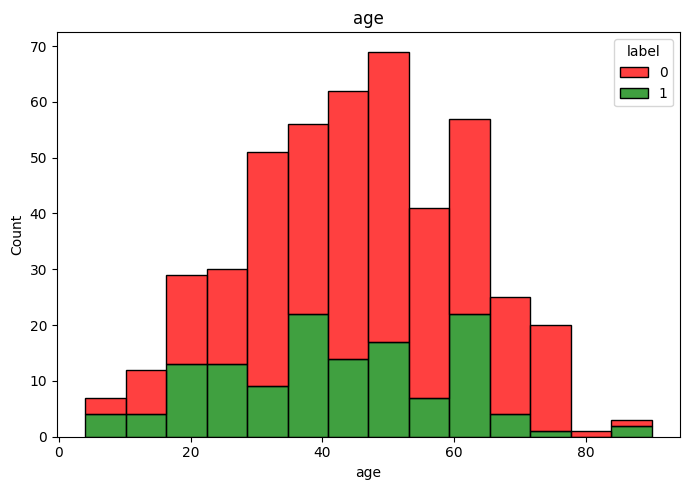

count    463.000000
mean      44.881210
std       16.308741
min        4.000000
25%       33.000000
50%       45.000000
75%       57.500000
max       90.000000
Name: age, dtype: float64

In [7]:
plot_histogram('age', X, y)
X['age'].describe()

In [8]:
shapiro_test('age', X)


Shapiro-Wilk test result for normality:
Statistic: 0.9932, p-value: 0.0345
The data does not appear to be normally distributed (reject H0).


We see that the age behaves almost like a normal distribution.

It will probably be difficult to deal with the extreme values, because usually the standard values for the other variables will be known only for adults.

We should consider the option of turning this variable into a categorical one (for example, intervals of around 15 years).

### Gender (female)

According to one source olnine, "liver disease affects males twice as often as females". We can check that.

Source:
https://my.clevelandclinic.org/health/diseases/17179-liver-disease

Additional information provided by the source:
- There are 4 stages of liver disease: hepatitis, fibrosis, cirrhosis and liver failure.

In [9]:
def contingency_table_and_test(var, X, y):
    """
    Display the contingency table (in absolute and relative frequences)
    of the var of X and the label (of y).
    Also perform a Chi-square test for independence.
    """

    # Absolute frequency
    contingency_table_abs = pd.crosstab(X[var], y, margins=True)
    print(f"\nAbsolute frequency contingency table for {var} and label:")
    print(contingency_table_abs)

    # Relative frequency
    contingency_table_rel = pd.crosstab(X[var], y, margins=True, normalize=True)
    print(f"\nRelative frequency contingency table for {var} and label:")
    print(contingency_table_rel)

    # Chi-square test for independence
    chi2, p, _, _ = stats.chi2_contingency(contingency_table_abs.iloc[:-1, :-1])  # Exclude totals for the test
    print(f"\nChi-square test result for {var} vs. label:")
    print(f"Chi2 statistic: {chi2:.4f}, p-value: {p:.4f}")
    if p < 0.05:
        print("There is a significant association between the categorical variable and the label (reject H0).")
    else:
        print("There is no significant association between the categorical variable and the label (fail to reject H0).")

contingency_table_and_test('female', X, y)



Absolute frequency contingency table for female and label:


label     0    1  All
female               
0.0     257   94  351
1.0      74   38  112
All     331  132  463

Relative frequency contingency table for female and label:
label          0         1       All
female                              
0.0     0.555076  0.203024  0.758099
1.0     0.159827  0.082073  0.241901
All     0.714903  0.285097  1.000000

Chi-square test result for female vs. label:
Chi2 statistic: 1.7922, p-value: 0.1807
There is no significant association between the categorical variable and the label (fail to reject H0).


We see that the dataset is very imbalanced.

We have that it is composed of a 71% of healthy subjects versus 29% of liver-patients.
At the same time, of a 76% of men and a 24% of women.

We see that the Chi-square suggests independence between those two variables. But looking at the contingency table, we see that there are 3 times more men than women, but less than 3 times more male liver-patients than female.

We see that the affirmation that males have more chances to be liver-patients than women is not reflected in out dataset. This suggests that this dataset may be biased: we may have less liver-patient males than what we should, according to our source.

We will take this into account, although this means that the test dataset will have a similar bias (if its samples were selected randomly).

### Total and direct bilirubin (tb, db)

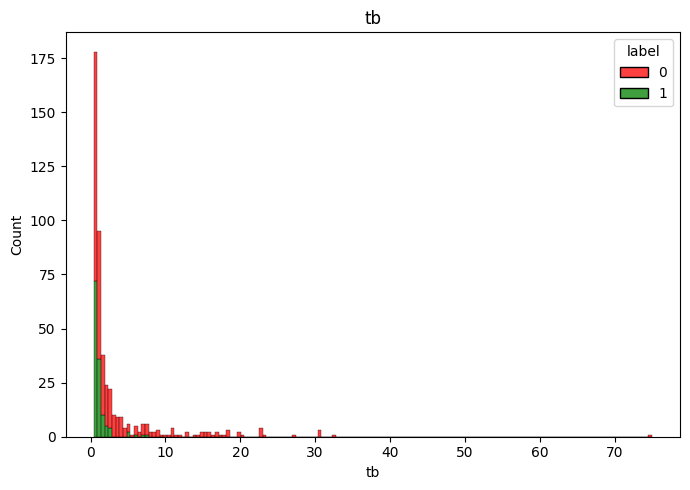

count    463.000000
mean       3.278834
std        6.114760
min        0.400000
25%        0.800000
50%        1.000000
75%        2.700000
max       75.000000
Name: tb, dtype: float64

In [10]:
plot_histogram('tb', X, y)
X['tb'].describe()

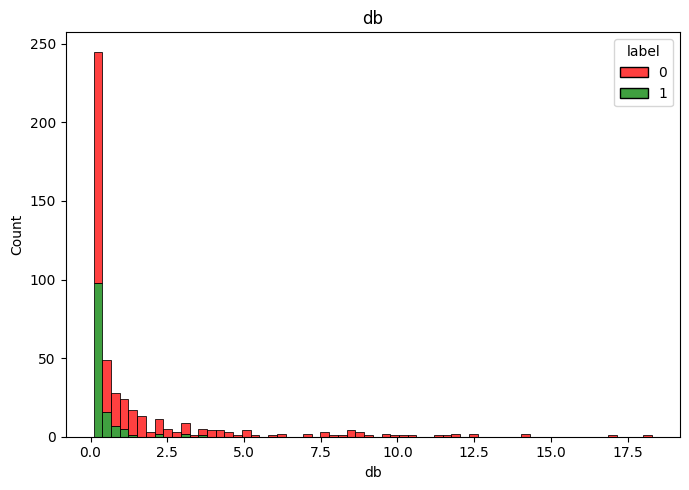

count    463.000000
mean       1.445788
std        2.675304
min        0.100000
25%        0.200000
50%        0.300000
75%        1.300000
max       18.300000
Name: db, dtype: float64

In [11]:
plot_histogram('db', X, y)
X['db'].describe()

According to some sources, bilirubin is distributed in 3 metrics: direct, indirect and total. We are given 2 in the dataset, but the other can be computed easily.

We have found that bilirubin is related to hepatitis, and that it varies across different ages and genders, and can be affected by pharmaceutical drugs.

We have some references for the standard values (in mg/dL (miligrams / deciliter)):
- Direct bilirubin: (0, 0.3) for adults.
- Indirect bilirubin: (0.1, 1.2) for adults.
- Total bilirubin: (0.3, 1.9) for adults, a little less for minors. (1, 12) for newborns. 

We have found that usually, lower values of bilirubin are non-problematic. It's higher values (direct bilirubin, most importantly) what relates to hepatitic problems. Indirect bilirubin is not so related to liver-patients. We will not compute it

In our dataset, this information is totally reflected. We see that most values are quite low, and basically all of the healthy individuals have low values. We see that some others have unsually high values. It is hard do know if those are outliers, because there are no human thresholds for the variable found online.

What we do found is critical (but possible) values that sugget liver-patients:
- Total bilirubin: > 12 for adults. > 15 for newborns.

But all these values can't confirm any decision. We can only suspect that higher values will increase the probability of being a liver-patients.

As a note, this variable is absolutely not normal and will require a transformation for some of the models.

Sources:

https://www.mayoclinic.org/es/tests-procedures/bilirubin/about/pac-20393041
https://emedicine.medscape.com/article/2074068-overview

### Alkaline phospotase (alkphos)

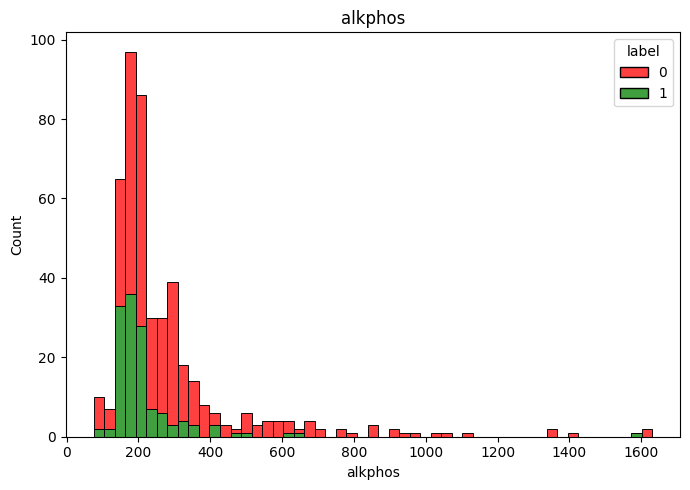

count     463.000000
mean      279.866091
std       211.283163
min        75.000000
25%       176.000000
50%       208.000000
75%       291.000000
max      1630.000000
Name: alkphos, dtype: float64

In [12]:
plot_histogram('alkphos', X, y)
X['alkphos'].describe()

Alkaline phospotase is a protein found in all body tissues. High values can be related to hepatithis, but also other non liver related problems.

The main problem with the standard values is that they depend on the laboratory where the analysis is done. We have joined different ranges into a wider range.

Broad normal values (in U/l (units / liter)):
- Children between 4 and 6 years: < 650
- Adults: < 240 for females, < 270 for males

We expect high values to increase the chance of being a liver-patient.

Note that there is a healthy patient with extremely high alkphos (around 1600). We can not suppose that this is related to liver-disease, as it may be related to bone-disease or something else.

Sources:

https://medlineplus.gov/spanish/pruebas-de-laboratorio/fosfatasa-alcalina/
https://www.webmd.com/es/digestive-disorders/prueba-fosfatasa-alcalina
https://www.elsevier.es/es-revista-atencion-primaria-27-articulo-por-que-aumentan-las-fosfatasas-13027626

### Alanine aminotransferase (sgpt) and aspartate aminotransferase (sgot)

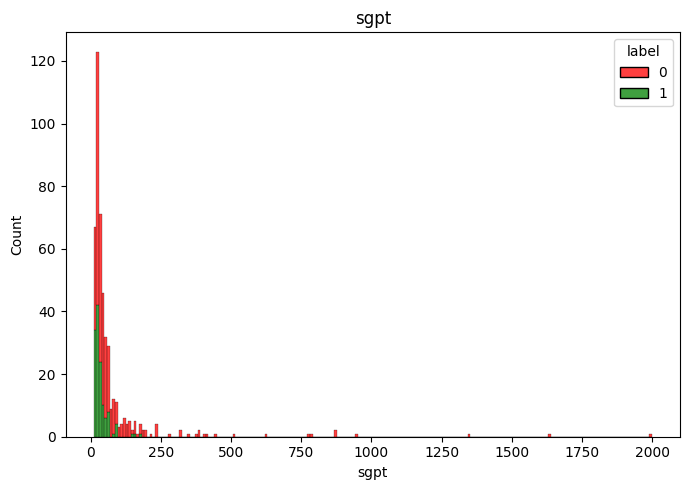

count     463.000000
mean       75.844492
std       169.289826
min        10.000000
25%        23.000000
50%        34.000000
75%        60.000000
max      2000.000000
Name: sgpt, dtype: float64

In [13]:
plot_histogram('sgpt', X, y)
X['sgpt'].describe()

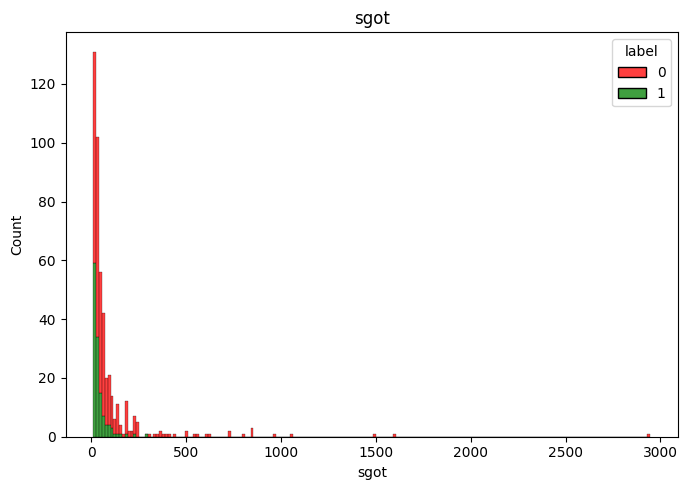

count     463.000000
mean       97.606911
std       212.114404
min        11.000000
25%        25.000000
50%        41.000000
75%        83.500000
max      2946.000000
Name: sgot, dtype: float64

In [14]:
plot_histogram('sgot', X, y)
X['sgot'].describe()

Alanine aminotransferase, a.k.a. ALT and SGPT, is an enzyme (a protein) found mainly in the liver. High values can be related to liver-patients. Normal values can vary between laboratories.

Broad normal values for SGPT (in U/l (units / liter)):
- Males: (7, 56) (any age >1 year)
- Females: (7, 45) (any age >1 year)

Aspartate aminotransferase, a.k.a. AAST and SGOT is another enzyme usually associated with liver health. Normal values also vary across laboratories and age, gender, race and weight. Again, high values may increase the chances to be a liver-patient.

Usual normal values for SGOT (in U/l (units / liter)):
- (5, 40)

According to one source, "the most efficient aminotransferase threshold for diagnosing acute liver injury is 7 times the upper limit (sensitivity and specificity >95%)". This would mean that having a value greater than 400 should hihgly increase the chances of being a liver-patient in our model.

Sources:

https://www.webmd.com/es/digestive-disorders/prueba-sangre-alt-alanina-aminotransferasa
https://medlineplus.gov/spanish/pruebas-de-laboratorio/prueba-de-sangre-de-alt/
https://www.mayoclinic.org/es/tests-procedures/alanine-aminotransferase-alt-test/about/pac-20582729
https://my.clevelandclinic.org/health/diagnostics/22147-aspartate-transferase-ast
https://www.ncbi.nlm.nih.gov/books/NBK559278/#:~:text=Alanine%20aminotransferase%20(ALT)%20is%20an,injury%20due%20to%20many%20causes.

### Total proteins (tp)

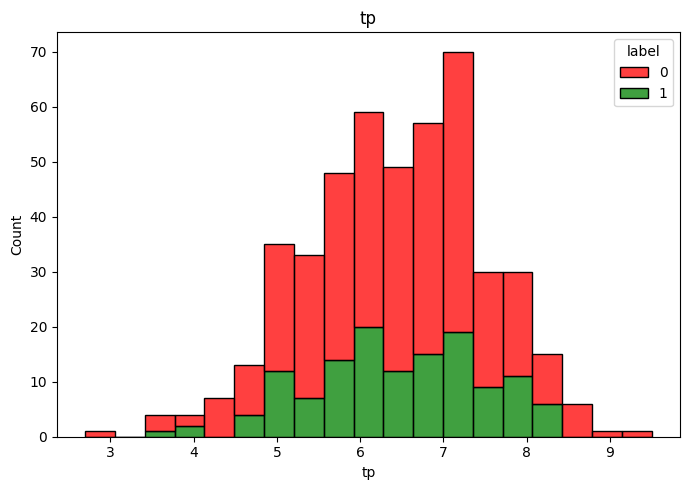

count    463.000000
mean       6.422030
std        1.051648
min        2.700000
25%        5.700000
50%        6.500000
75%        7.100000
max        9.500000
Name: tp, dtype: float64

In [15]:
plot_histogram('tp', X, y)
X['tp'].describe()

A total protein test can help predict liver disease, if the levels are too low.

Nevertheless, in our dataset we do not see a clear relationship, so we can not suspect any specific behavior.

Sources:

https://www.nhs.uk/tests-and-treatments/total-protein-test/
https://medlineplus.gov/spanish/pruebas-de-laboratorio/proteinas-totales-y-relacion-albumina-globulinaa-g/

In [16]:
shapiro_test('tp', X)


Shapiro-Wilk test result for normality:
Statistic: 0.9936, p-value: 0.0458
The data does not appear to be normally distributed (reject H0).


Even though the Shpario-Wilks test fails to check normality, the p-value is almost 0.05 so we could use this variable as a normal.

### Albumin (alb) and albumin-globulin ratio (a/r)

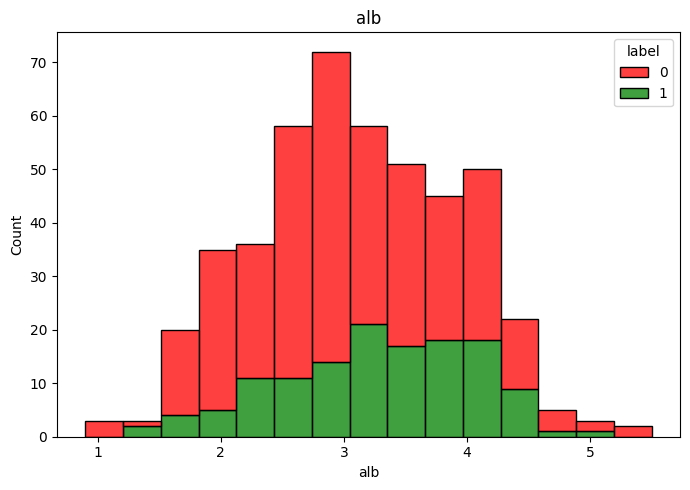

count    463.000000
mean       3.109935
std        0.793036
min        0.900000
25%        2.500000
50%        3.100000
75%        3.700000
max        5.500000
Name: alb, dtype: float64

In [17]:
plot_histogram('alb', X, y)
X['alb'].describe()

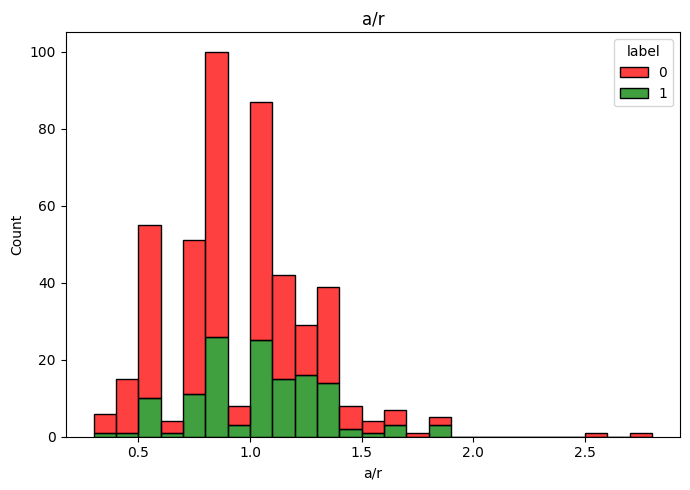

count    463.000000
mean       0.942916
std        0.318381
min        0.300000
25%        0.700000
50%        0.920000
75%        1.100000
max        2.800000
Name: a/r, dtype: float64

In [18]:
plot_histogram('a/r', X, y)
X['a/r'].describe()

Albumins and globulins are proteins. Lower values can be related to liver-patients.

Normal values (in g/dL (grams / deciliter)):
- (3.5, 5), a bit broader for children.

Sources:

https://medlineplus.gov/spanish/pruebas-de-laboratorio/proteinas-totales-y-relacion-albumina-globulinaa-g/
https://www.topdoctors.es/diccionario-medico/albumina/

In [19]:
shapiro_test('alb', X)


Shapiro-Wilk test result for normality:
Statistic: 0.9921, p-value: 0.0153
The data does not appear to be normally distributed (reject H0).


This variable looks quite normal but has a very low p-value on the Shapiro test.

### Conclusions

We can expect that, after training some models, some specific variables will positevly increase the chances of classifying a patient as a liver-patient, and others will decrease the chances (when the value of the variable increases):

Higher bilirubin (tb or db), alkphos, sgpt and sgot are related to liver-disease.
Lower albumin and lower a/r are related to liver-disease.

About outliers, we can not be sure that any of the individuals are outliers because we do not know any upper threshold for our variables. We will have to suppose that there are not outliers.

For every model, we will have to make an additional pre-processing if that model assumes:
- Class balance
- Gaussianity
- Equal scales (normalization)

There are some possible changes that can be made to the dataset too:
- Treating 'age' as a categorical with multiple classes.
- Creating new variables, such as: 'Gloubin': glo = alb/(a/r), (<= alb / glo = a/r)

## Variable correlation

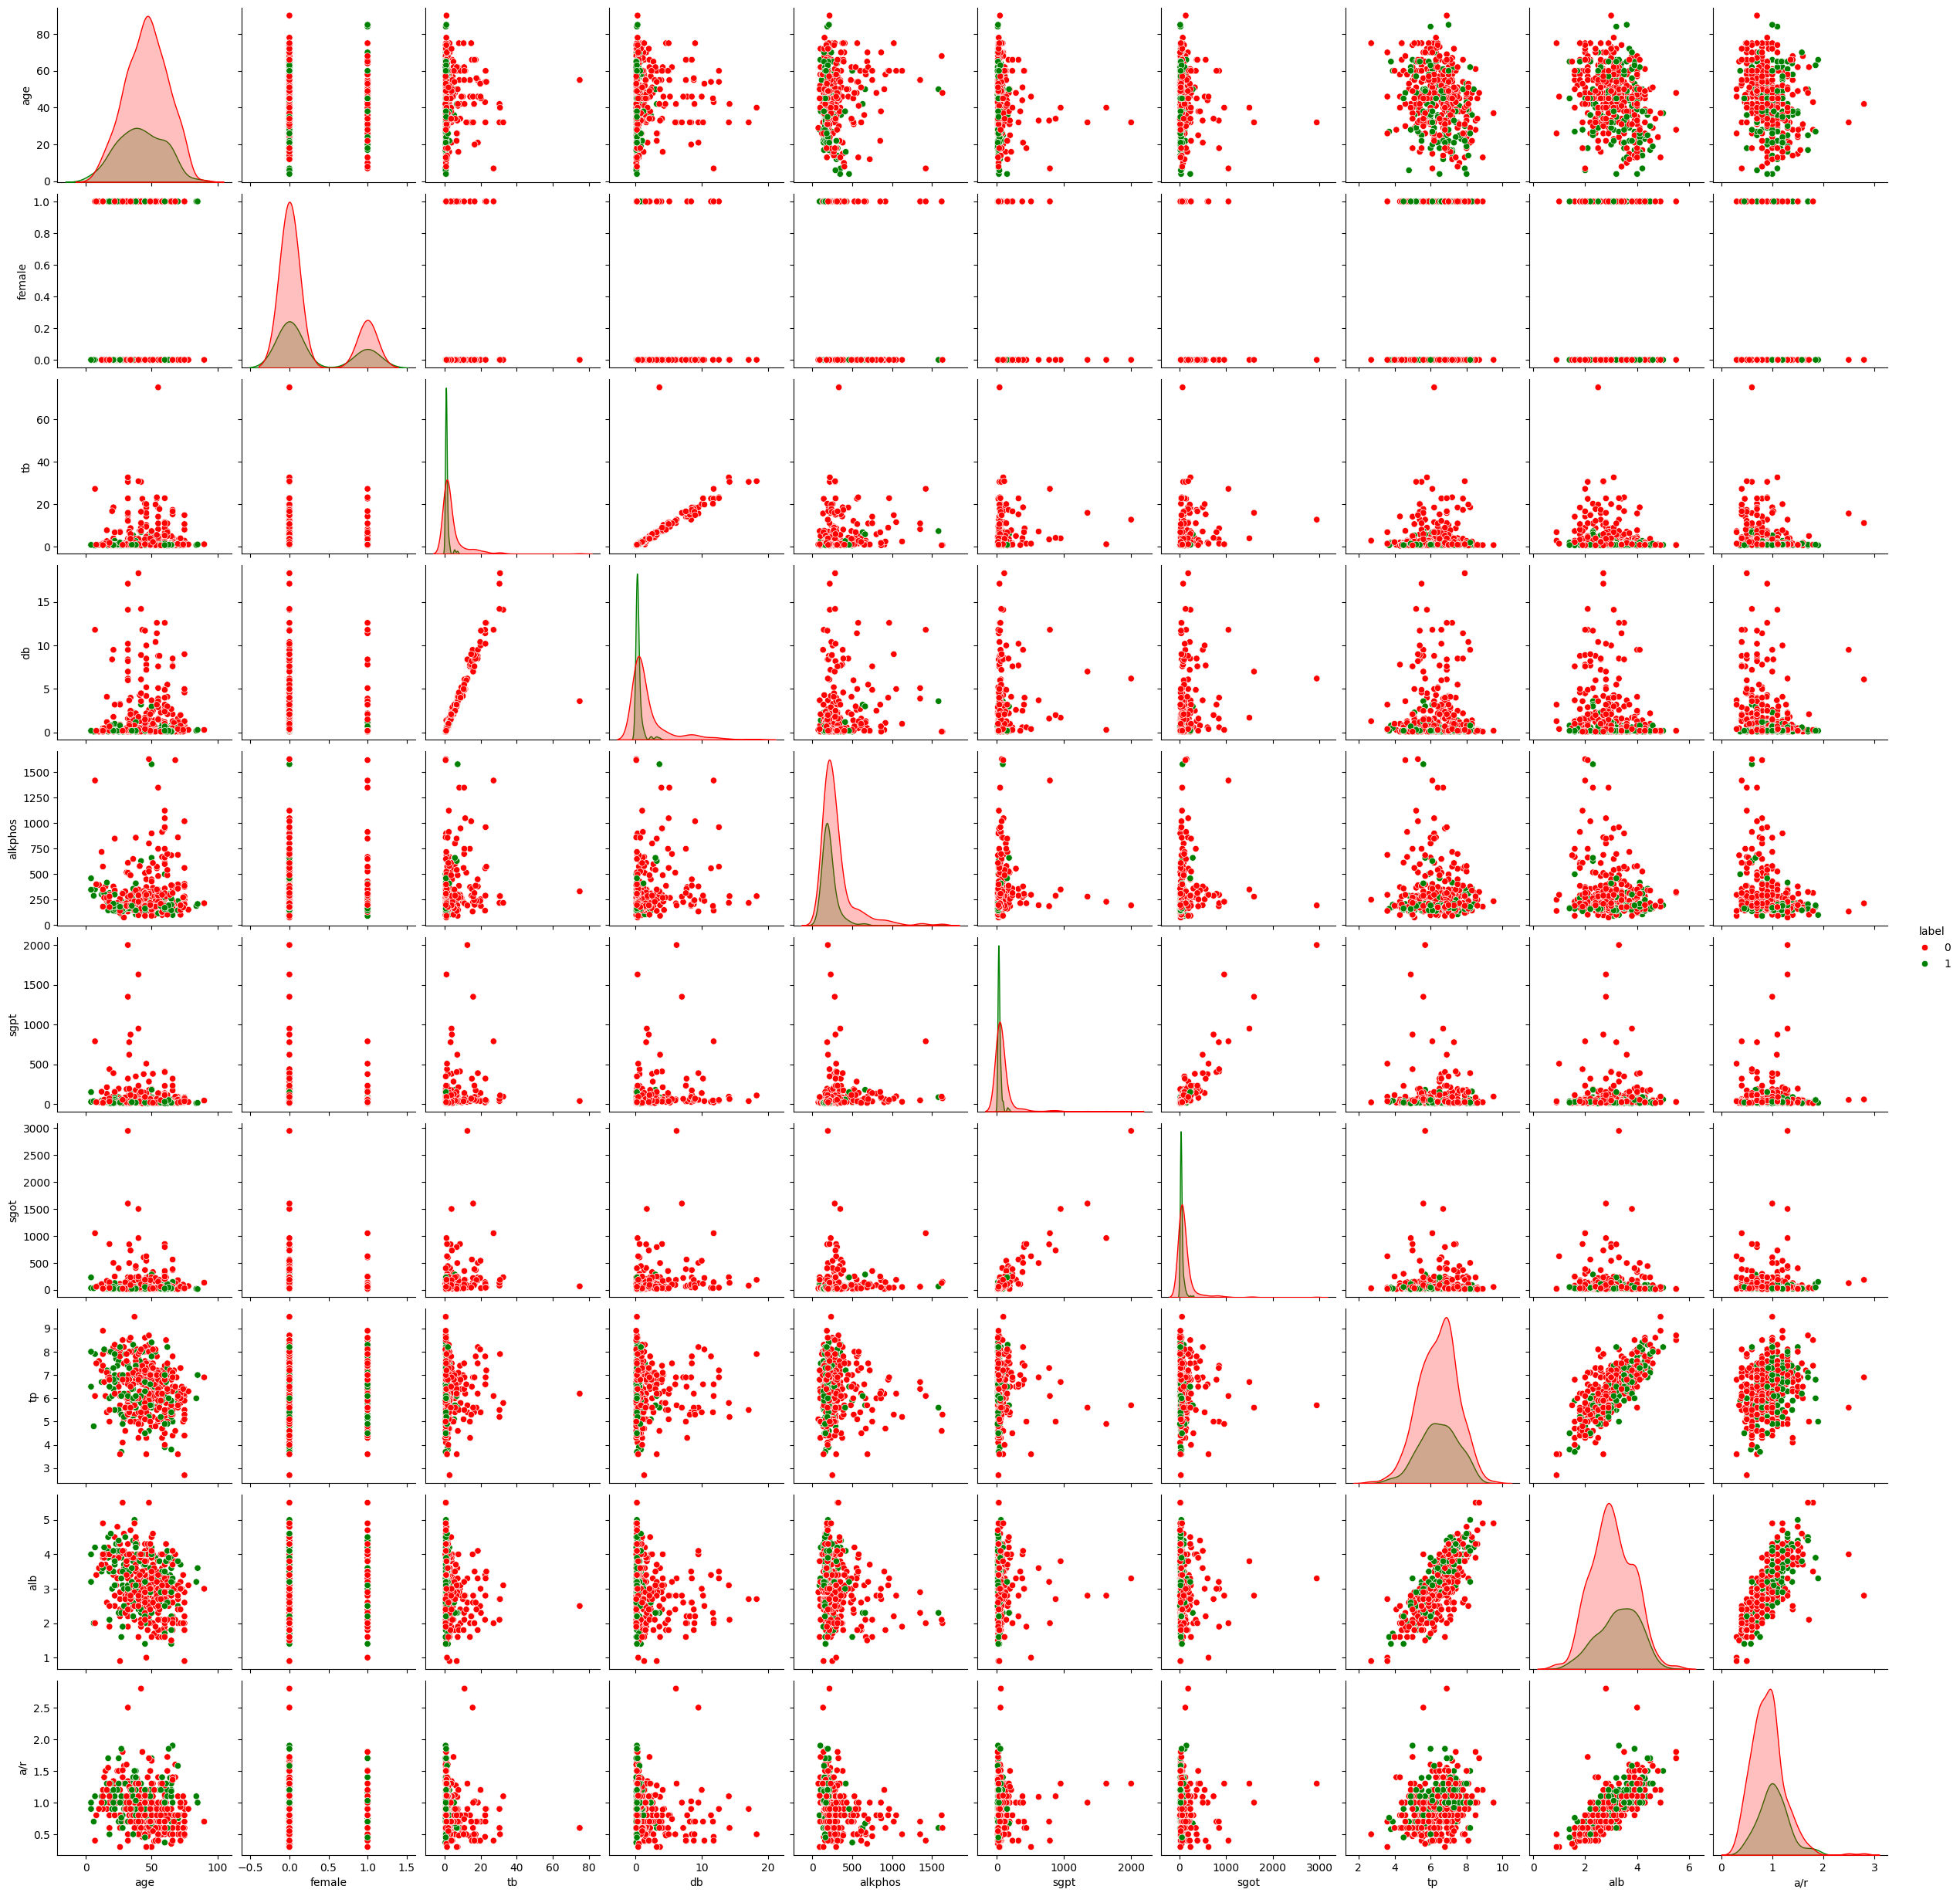

In [20]:
sns.pairplot(data=X.join(y), hue='label', palette=custom_palette)

### Relationships:

There are some highly correlated variables, which may bring problems:
- 'tb' with 'db'

Also some not so high correlations:
- 'sgot' with 'sgpt'
- 'alb' with 'tp'
- 'alb' with 'a/r' (expected)

# 2. Pre-processing

Because we are using a variety of models with different assumptions, we will use some of the following pre-processing functions before training the models, just as we need them for each case. We will be able to reuse these functions for different models.

In [21]:
def scale(X: pd.DataFrame, scaler=None):   
    """
    Scale the variables to (0, 1) using MinMaxScaler.
    Returns a new dataset and a scaler. Does not modify the original X.
    """
    X_new = X.copy()
    
    if scaler is None: 
        scaler = MinMaxScaler()
        X_scaled_array = scaler.fit_transform(X_new)
    else: 
        X_scaled_array = scaler.transform(X_new)
    
    X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns, index=X.index)
    
    return X_scaled, scaler


def box_cox_transform(X: pd.DataFrame) -> pd.DataFrame:
    """
    Apply a Box-Cox tranformation to all features on X.
    Returns a new dataset. Does not modify the original X.
    """
    X_new = X.copy()
    transformer = PowerTransformer(method='box-cox', standardize=True)
    X_transformed = transformer.fit_transform(X_new + 1e-6)  # Add small value to avoid zero
    return pd.DataFrame(X_transformed, columns=X.columns)


def oversample_smote(X: pd.DataFrame, y: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Apply SMOTE to balance the training fold (X, y)
    Returns new datasets. Does not modify the original X and y.
    """
    X_new = X.copy()
    y_new = y.copy()
    sm = SMOTE(random_state=42)
    return sm.fit_resample(X_new, y_new)

# 3. Decision making

We will decide on:

- The metrics to focus on
- The models to study
- The data splits (train, evaluation and test)

## Metric selection

Kaggle sorts teams by their F-score. We will focus on this one as it is the objective of the competition.

Due to the given context, it is far more dangerous to diagnose a liver patient as healthy, it is to say, to diagnose a real 0 as a predicted 1. Considering that 1 is positive and 0 is negative, we want to minimize false positives.

Specificity and precision aim to minimize those. But because precision is already included in the formula of the F-score, while specificity is not, we will focus on F-score primarily and also on specificity. Also better specificity means better capability to cover actual negatives (in our case, to cover liver patients) which is what we considered important.

## Models to use

Our goal is to classify, so we will first list all the supervised learning classification algorithms seen during the course:

- Generative classifiers: Naive Bayes, LDA and QDA
- KNN
- Discriminative classifiers: logistic regression, SVM, decision trees (also random forests)

And also the meta-algorithms:
- Bagging
- Boosting: AdaBoost, gradient boosting
- Stacking
- K-fold cross-validation

## Train / validation / test split

We aim to select one final model. These means that we will need to use some of the data to compare the models, so we will need:
- A training split. For each model we will divide this training split further, because we will use some type of validation for every model that requires it. The training phase will allow to get a training and in some cases a validation error, capable to predict the test error.
- A "comparison" split. Similar to a test split, but we will use it to select the model. This means we are using this information and is not a test set, properly said.
- A test set. This will be the public set provided at the Kaggle page. To avoid overfitting, we won't use the information provided by the test set, unless extreme cases (such as an incomprehensible drop in the F1-score). The final private test set will then be the real and only test set.

In [22]:
# Data split
X_train, X_compare, y_train, y_compare = train_test_split(X, y, test_size=0.33, random_state=42)
# Test is contained in a different dataset. We do not have access to the labels.

# Scores tables

training_scores = pd.DataFrame(index=[], columns= ['F-score', 'Specificity', 'Accuracy', 'Precision', 'Recall'])
"""Training phase scores."""

comparing_scores = pd.DataFrame(index=[], columns= ['F-score', 'Specificity', 'Accuracy', 'Precision', 'Recall'])
"""Comparing (pseudo-testing) phase scores."""

'Comparing (pseudo-testing) phase scores.'

# 4. Model training

We will now proceed to train the models one by one.

## Generative classifiers

We will first make a try with Naive Bayes, LDA and QDA on default configuration. It is important to use the appropiate pre-processing and to cross-validate.

Niave Bayes assumes that the features are conditionally independent given the class. This is going to be a problem, because we have already seen that some variables are affected by the age and gender of the patient, and are highly correlated between each other. NB also assumes a specific distribution, such as gaussian.

LDA assumes that the features in each class follow a multivariate gaussian, like QDA. They differ in that LDA also assumes equal covariance matrices for all classes.

This means that we will use a pre-processing with Box-Cox transform for all three.

In [23]:
# Function to perform k-fold CV and evaluate models
def cross_validate_model(model, X, y, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    metrics = {
        'F-score': [],
        'Specificity': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': []
    }

    for train_index, val_index in skf.split(X, y):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        
        metrics['F-score'].append(f1_score(y_val_fold, y_pred, zero_division=0))
        metrics['Specificity'].append(specificity_score(y_val_fold, y_pred))
        metrics['Accuracy'].append(accuracy_score(y_val_fold, y_pred))
        metrics['Precision'].append(precision_score(y_val_fold, y_pred, zero_division=0))
        metrics['Recall'].append(recall_score(y_val_fold, y_pred, zero_division=0))
    
    # Average across folds
    return {metric: np.mean(scores) for metric, scores in metrics.items()}

In [24]:
# Pre-process
X_train_boxcox = box_cox_transform(X_train)

# Choose models
models = {
    'GaussianNB_raw': GaussianNB(),
    'LDA_raw': LDA(),
    'QDA_raw': QDA()
}

# Cross-validate and compute metrics on the training set
for name, model in models.items():
    scores = cross_validate_model(model, X_train_boxcox, y_train)
    training_scores.loc[name] = scores

In [25]:
training_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_raw,0.511927,0.638283,0.645161,0.418537,0.663399
LDA_raw,0.297972,0.892828,0.706452,0.467460,0.220915
QDA_raw,0.395978,0.728081,0.645161,0.375565,0.431373


We see that the Naive Bayes, which was expected to be the worst, is actually the best of those 3.

The main reason could easily be the set imbalance. To fix this, we will apply another pre-processing that uses a resampling method, such as SMOTE. We apply this on the train because the test shouldn't be manipulated (there would be data leakage there). Also, the oversampling should be done after the Box-Cox transformation.

In [26]:
# Pre-process
X_train_boxcox_smote, y_train_smote = oversample_smote(X_train_boxcox, y_train)

# Choose models
models = {
    'GaussianNB_smote': GaussianNB(),
    'LDA_smote': LDA(),
    'QDA_smote': QDA()
}

# Cross-validate and compute metrics on the training set
for name, model in models.items():
    scores = cross_validate_model(model, X_train_boxcox_smote, y_train_smote)
    training_scores.loc[name] = scores

In [27]:
training_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_raw,0.511927,0.638283,0.645161,0.418537,0.663399
LDA_raw,0.297972,0.892828,0.706452,0.467460,0.220915
QDA_raw,0.395978,0.728081,0.645161,0.375565,0.431373
GaussianNB_smote,0.716197,0.584545,0.687640,0.656222,0.790404
LDA_smote,0.700110,0.616162,0.681049,0.659913,0.745960
QDA_smote,0.741663,0.589596,0.709963,0.671125,0.830303


We can see a very high increase in all of the models' performance after having applied the SMOTE. Specifically, the F-score increases, as well as the precision and recall, in exchange for some of the specificity. The accuracy simply varies.

This is when our still untouched dataset comes into action. The "compare" dataset will allow to see if the overall training phase has been properly executed, as these high performances could not reflect the real performance on the dataset.

In [28]:
# Pre-process
X_compare_boxcox = box_cox_transform(X_compare)

# Choose models
models = {
    'GaussianNB_smote': GaussianNB(),
    'LDA_smote': LDA(),
    'QDA_smote': QDA()
}

# Train on the training set and compute metrics on the comparing set
for name, model in models.items():
    scores = evaluate_on_holdout(model, X_train_boxcox_smote, y_train_smote, X_compare_boxcox, y_compare)
    comparing_scores.loc[name] = scores

In [29]:
comparing_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
QDA_smote,0.559322,0.635514,0.660131,0.458333,0.717391


What conclusions can we get from this?

First of all, it seems that the F-score has dropped from values around 70% to values around 60%, so it may be seem that we are not evaluating properly. But this is not the case.

We have to compare this performance to the performance that we get without using the SMOTE, that will be similar to the evaluation performance that we got initially on those 3 cclassifiers.

In [30]:
# Choose models
models = {
    'GaussianNB_raw': GaussianNB(),
    'LDA_raw': LDA(),
    'QDA_raw': QDA()
}

# Train on the training set and compute metrics on the comparing set
for name, model in models.items():
    scores = evaluate_on_holdout(model, X_train_boxcox, y_train, X_compare_boxcox, y_compare)
    comparing_scores.loc[name] = scores

In [31]:
comparing_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
QDA_smote,0.559322,0.635514,0.660131,0.458333,0.717391
GaussianNB_raw,0.576271,0.644860,0.673203,0.472222,0.739130
LDA_raw,0.289855,0.878505,0.679739,0.434783,0.217391
QDA_raw,0.530612,0.757009,0.699346,0.500000,0.565217


This is where the true comparison is valuable: when predicting over unseen information randomely chosen from our original dataset, which model performs better?

LDA had a very low F-score and a high specificty when trained without oversampling, which indicates the effect of the imbalance. This effect is higjly reduced after applying SMOTE.

The Naive Bayes, surprisingly, has lower performance, except for the recall, after the oversampling. We should remember that our dataset has highly correlated variables, which could explain why the NB generally performs worse when having more individuals to be trained on.

QDA's performance has increased a bit, in F-score and recall, in exchange for specificity, accuracy and precision. Again, this reflects that the guesses are more complex now, not as simple as saying "0" for most of the cases.

From thse 3 models, the Naive Bayes should not be chosen, as we do not match its assumptions. The LDA has an F-score quite better than the QDA, but has a higher recall and a lower specificity, which is not exactly what we are looking for.

By default, we have using the maximum a posteriori decision rule. We have considered using some bayessian cost to minimize, but it would produce a similar result than the SMOTE, as our dataset is not extremely imbalanced and we are looking to maximize the F-score (not just the recall or specificity).

In order to check our prior assumptions on the variables and their behavior, we can see some parameters of the LDA, fitted with all the training data.

In [32]:
model_LDA = LDA().fit(X_train_boxcox_smote, y_train_smote)


print('Priors:', model_LDA.priors_, '\n')

print('Means:\n')
means =pd.DataFrame(model_LDA.means_)
means.columns=X.columns
means.index = model_LDA.classes_
means

Priors: [0.5 0.5] 

Means:



,age,female,tb,db,alkphos,sgpt,sgot,tp,alb,a/r
0,0.057047,-0.014005,0.188671,0.159075,0.130550,0.159024,0.166677,-0.007263,-0.073327,-0.095392
1,-0.148898,-0.061339,-0.481369,-0.406406,-0.343063,-0.392667,-0.407939,0.067392,0.233632,0.256048


In [33]:
print('Intercepts:')
intercepts = pd.DataFrame(model_LDA.intercept_)
print(intercepts)

print('Coefs:')
coefs = pd.DataFrame(model_LDA.coef_)
coefs.columns =X.columns
coefs

Intercepts:
          0
0 -0.266812
Coefs:


,age,female,tb,db,alkphos,sgpt,sgot,tp,alb,a/r
0,-0.278055,-0.325823,-1.596622,1.033009,-0.214207,-0.378507,-0.211234,-1.428439,1.839257,-0.760425


The priors are 50%, because we have used oversampling. The means are clearly different between both labels.

The intercept suggests that, by default, we classify an individual as a liver-patient. Then, the coefficients suggest that an individual has more chances of being a patient if its a female, and if age, total bilirubin, alkaline phosphotase, sgpt, sgot, tp and a/r get high. It only reduces the chances when the direct bilirubin and the albumin are high.

Generally, this was the expected behavior.

It seems weird that direct bilirubin should also increase the chances. Because total bilirubin is just the sum of direct and indirect, and indirect is not as important, let's try to fit an LDA removing this variable and check what happens then.

In [34]:
# Pre-process
X_train_boxcox_smote_noTB = X_train_boxcox_smote.drop('tb', axis=1)
X_compare_boxcox_noTB = X_compare_boxcox.drop('tb', axis=1)

# Validation error
print(evaluate_on_holdout(LDA(), X_train_boxcox_smote_noTB, y_train_smote, X_compare_boxcox_noTB, y_compare))

{'F-score': 0.5714285714285714, 'Specificity': np.float64(0.5887850467289719), 'Accuracy': 0.6470588235294118, 'Precision': 0.45, 'Recall': 0.782608695652174}


In [35]:
model_LDA_2 = LDA().fit(X_train_boxcox_smote_noTB, y_train_smote)

print('Intercepts:')
intercepts = pd.DataFrame(model_LDA_2.intercept_)
print(intercepts)

print('Coefs:')
coefs = pd.DataFrame(model_LDA_2.coef_)
coefs.columns =X_compare_boxcox_noTB.columns
coefs

Intercepts:
          0
0 -0.236734
Coefs:


,age,female,db,alkphos,sgpt,sgot,tp,alb,a/r
0,-0.303045,-0.355638,-0.434704,-0.256505,-0.471441,-0.236986,-1.38107,1.825789,-0.747892


We can see that the model performs worse. It has less information, and db was compesating the big coefficient for tb, so there was no problem there.

We have to keep the total bilirubin.

## K-nearest neighbors

We will try a K nearest neighbors, with quite some different values for k.

In [36]:
# Table to compare k hyperparameter
index = pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
knn_scores = pd.DataFrame(index=index, columns= ['F-score', 'Specificity', 'Accuracy', 'Precision', 'Recall'])
"""KNN training phase scores."""

# Training split on train_knn and val_knn
X_train_knn, X_val_knn, y_train_knn, y_val_knn = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Range of k values to test
k_values = range(1, 30, 2)

# Loop over k values (scaling only for the training split)
for k in k_values:
    
    # Scale train and val, according to train
    X_train_knn_scaled, scaler = scale(X_train_knn)
    X_val_knn_scaled, _, = scale(X_val_knn, scaler)

    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_knn_scaled, y_train_knn)
    knn_scores.loc[('KNN', k), :] = metrics_dict(y_val_knn, knn.predict(X_val_knn_scaled))

# Sort the results by F-score
knn_scores_sorted = knn_scores.sort_values(by='F-score', ascending = False)
print(knn_scores_sorted)

           F-score Specificity  Accuracy Precision Recall
model k                                                  
KNN   1    0.45614     0.75641  0.699029   0.40625   0.52
      13  0.368421    0.923077   0.76699  0.538462   0.28
      3   0.352941    0.782051  0.679612  0.346154   0.36
      15  0.333333    0.935897   0.76699  0.545455   0.24
      5   0.326531    0.794872  0.679612  0.333333   0.32
      9   0.292683    0.871795  0.718447     0.375   0.24
      7   0.272727    0.833333   0.68932  0.315789   0.24
      11   0.25641    0.884615  0.718447  0.357143    0.2
      17  0.137931    0.974359  0.757282       0.5   0.08
      21  0.137931    0.974359  0.757282       0.5   0.08
      19  0.129032    0.948718  0.737864  0.333333   0.08
      23  0.071429    0.974359  0.747573  0.333333   0.04
      27  0.071429    0.974359  0.747573  0.333333   0.04
      25  0.068966    0.961538  0.737864      0.25   0.04
      29       0.0    0.987179  0.747573       0.0    0.0


We can see that the performance is not as good as the previous' models, and decreases with k. Let's try with the oversampled training set.

In [37]:
# Table to compare k hyperparameter
index = pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
knn_smote_scores = pd.DataFrame(index=index, columns= ['F-score', 'Specificity', 'Accuracy', 'Precision', 'Recall'])
"""KNN training phase scores, using SMOTE oversampled training set."""

# Pre-process
X_train_smote, y_train_smote = oversample_smote(X_train, y_train)

# Training split on train_knn and val_knn
X_train_smote_knn, X_val_smote_knn, y_train_smote_knn, y_val_smote_knn = train_test_split(X_train_smote, y_train_smote, test_size=0.33, random_state=42)

# Range of k values to test
k_values = range(1, 30, 2)

# Loop over k values
for k in k_values:

    # Scale train and val, according to train
    X_train_smote_knn_scaled, scaler = scale(X_train_smote_knn)
    X_val_smote_knn_scaled, _ = scale(X_val_smote_knn, scaler)

    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_smote_knn_scaled, y_train_smote_knn)
    knn_smote_scores.loc[('KNN', k), :] = metrics_dict(y_val_smote_knn, knn.predict(X_val_smote_knn_scaled))

# Sort the results by F-score
knn_smote_scores_sorted = knn_smote_scores.sort_values(by='F-score', ascending = False)
print(knn_smote_scores_sorted)

           F-score Specificity  Accuracy Precision    Recall
model k                                                     
KNN   1    0.76129    0.675325      0.75  0.702381  0.830986
      3   0.675325    0.597403  0.662162  0.626506  0.732394
      7   0.654088    0.532468  0.628378  0.590909  0.732394
      13  0.654088    0.532468  0.628378  0.590909  0.732394
      29  0.645963    0.506494  0.614865  0.577778  0.732394
      5    0.64557    0.532468  0.621622  0.586207   0.71831
      15  0.636364    0.558442  0.621622  0.590361  0.690141
      23  0.632911    0.519481  0.608108  0.574713  0.704225
      27  0.625767    0.467532  0.587838  0.554348   0.71831
      9   0.620253    0.506494  0.594595  0.563218  0.690141
      11  0.619355    0.532468  0.601351  0.571429  0.676056
      21  0.619355    0.532468  0.601351  0.571429  0.676056
      25  0.616352    0.493506  0.587838  0.556818  0.690141
      17   0.61039    0.532468  0.594595  0.566265  0.661972
      19   0.61039    0.

We suspect that something similar to what happened with generative classifiers happens again. The evaluation error is quite low on the imbalanced dataset. Let's use the comparison dataset with the some of the ks, as they have similar F-scores.

In [38]:
# Pre-process

X_train_smote_scaled, scaler = scale(X_train_smote)
X_compare_smotescaled, _ = scale(X_compare, scaler)

# Choose models
models = {
    '1NN_smote': KNeighborsClassifier(n_neighbors=1),
    '3NN_smote': KNeighborsClassifier(n_neighbors=3),
    '7NN_smote': KNeighborsClassifier(n_neighbors=7),
    '13NN_smote': KNeighborsClassifier(n_neighbors=13),
}

# Train on the training set and compute metrics on the comparing set
for name, model in models.items():
    scores = evaluate_on_holdout(model, X_train_smote_scaled, y_train_smote, X_compare_smotescaled, y_compare)
    comparing_scores.loc[name] = scores

In [39]:
comparing_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
QDA_smote,0.559322,0.635514,0.660131,0.458333,0.717391
GaussianNB_raw,0.576271,0.644860,0.673203,0.472222,0.739130
LDA_raw,0.289855,0.878505,0.679739,0.434783,0.217391
QDA_raw,0.530612,0.757009,0.699346,0.500000,0.565217
1NN_smote,0.375000,0.700935,0.607843,0.360000,0.391304
3NN_smote,0.388889,0.616822,0.568627,0.338710,0.456522
7NN_smote,0.442478,0.607477,0.588235,0.373134,0.543478
13NN_smote,0.363636,0.588785,0.542484,0.312500,0.434783


The scores of the KNN have dropped significantly when testing on the "comparison" set, becuase this split is inbalanced.

It seems that we will not use KNN for the final model. We couls try to improve the scores using different types of distances, but the KNN performs quite worse than the other models, and those other distances will not be able to make the performance increase that much.

## Logistic regression

We will train the logistic regression on the oversampled dataset using K-fold cross-validation.

This is confusing, but what we will do here is:
- Define a logistic regression model which will be trained by K-fold cross-validation to select the best hyperparameter.
- Cross-validate the defined model on K-fold cross-validation.

So, for each fold, an "internal" cross-validation is performed to select the best hyperparameters, then an "external" validation set is used to look for the metrics. This is the training phase. Then we will be able to use the "comparison" set to compare against the other models.

First, without scaling, then scaling, as an interesting effect occurs after seing both.

Also, we will use different solvers, as another interesting effect occurs.

Note: we can use a different solver because the dataset is quite little, to avoid some non-convergence errors on the optimization.

In [40]:
# Oversampled, non-scaled pre-processing (already done)

# Choose models
models = {
    'logreg_raw': LogisticRegressionCV(Cs= 20, random_state= 1, cv= 10, scoring= 'f1'),
    'logreg_liblinear': LogisticRegressionCV(Cs= 20, random_state= 1, cv= 10, scoring= 'f1', solver= 'liblinear')
}

# Cross-validate and compute metrics on the training set
for name, model in models.items():
    scores = cross_validate_model(model, X_train_smote, y_train_smote)
    training_scores.loc[name] = scores

c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_resu

In [41]:
# Oversamppled, scaled pre-processing (already done)

# Choose models
models = {
    'logreg_raw_scaled': LogisticRegressionCV(Cs= 20, random_state= 1, cv= 10, scoring= 'f1'),
    'logreg_liblinear_scaled': LogisticRegressionCV(Cs= 20, random_state= 1, cv= 10, scoring= 'f1', solver= 'liblinear')
}

# Cross-validate and compute metrics on the training set
for name, model in models.items():
    scores = cross_validate_model(model, X_train_smote_scaled, y_train_smote)
    training_scores.loc[name] = scores

In [42]:
training_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_raw,0.511927,0.638283,0.645161,0.418537,0.663399
LDA_raw,0.297972,0.892828,0.706452,0.467460,0.220915
QDA_raw,0.395978,0.728081,0.645161,0.375565,0.431373
GaussianNB_smote,0.716197,0.584545,0.687640,0.656222,0.790404
LDA_smote,0.700110,0.616162,0.681049,0.659913,0.745960
QDA_smote,0.741663,0.589596,0.709963,0.671125,0.830303
logreg_raw,0.735208,0.540404,0.694307,0.648829,0.848182
logreg_liblinear,0.724765,0.531414,0.683196,0.640360,0.834949
logreg_raw_scaled,0.731428,0.553838,0.694232,0.652865,0.834848
logreg_liblinear_scaled,0.732628,0.549394,0.694257,0.651860,0.839293


We see similar results on the training. Let's check the "comparison" set on the models that do not have convergence problems. We can simply use the liblinear solver for this.

In [43]:
# Oversampled, non-scaled pre-processing (already done)

# Choose models
models = {
    'logreg_liblinear': LogisticRegressionCV(Cs= 20, random_state= 1, cv= 10, scoring= 'f1', solver= 'liblinear')
}

# Train on the training set and compute metrics on the comparing set
for name, model in models.items():
    scores = evaluate_on_holdout(model, X_train_smote, y_train_smote, X_compare, y_compare)
    comparing_scores.loc[name] = scores


# Choose models
models = {
    'logreg_liblinear_scaled': LogisticRegressionCV(Cs= 20, random_state= 1, cv= 10, scoring= 'f1', solver= 'liblinear')
}

# Train on the training set and compute metrics on the comparing set
for name, model in models.items():
    scores = evaluate_on_holdout(model, X_train_smote_scaled, y_train_smote, X_compare_smotescaled, y_compare)
    comparing_scores.loc[name] = scores

In [44]:
comparing_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
QDA_smote,0.559322,0.635514,0.660131,0.458333,0.717391
GaussianNB_raw,0.576271,0.644860,0.673203,0.472222,0.739130
LDA_raw,0.289855,0.878505,0.679739,0.434783,0.217391
QDA_raw,0.530612,0.757009,0.699346,0.500000,0.565217
1NN_smote,0.375000,0.700935,0.607843,0.360000,0.391304
3NN_smote,0.388889,0.616822,0.568627,0.338710,0.456522
7NN_smote,0.442478,0.607477,0.588235,0.373134,0.543478
13NN_smote,0.363636,0.588785,0.542484,0.312500,0.434783


Interestingly, the logistic regression performs better on the "comparison" set when fitted with non-scaled data: all those performance measures are better.

Again, the drop between training and testing scores is due to the imbalanced test set.

The LDA still performs a bit better.

## Support vector machine

We will now work on different configurations of SVMs.

The following code performs cross-validation to find the optimal hyperparameter values for the SVM. Specifically, it tests different combinations of the two main SVM hyperparameters: C and gamma.

For both C and gamma, we generate _resolution_ exponentially spaced values using expo_range, resulting in a total of _resolution_ × _resolution_ combinations to evaluate.

For each combination, we run [_repetitions_] rounds of 5-fold cross-validation. Inside each fold, we scale the training and validation sets (according only to the training set to avoid information leaking) using a chosen scaler (e.g., StandardScaler or MinMaxScaler), fit the model, and compute the F1-score. This results in a total of [5 × _repetitions_] F1-scores per parameter pair. We compute the average score and store it in a matrix of shape [_resolution_ × _resolution_].

At the end, we identify the best-performing parameter combinations and select the final values (e.g., by averaging the top-5). We also display a heatmap showing how performance changes across different C and gamma values.

In [45]:
# Customizable settings
repetitions = 10        # How many repetitions of k-fold cross-validation for each hyperparameter combination
resolution = 15         # Grid resolution (number of values for C and gamma)

# Define the range of C and gamma values using exponential separation
C_values = expo_range(0.01, 500, resolution)
gamma_values = expo_range(0.001, 4, resolution)
scores_matrix = np.zeros((len(C_values), len(gamma_values)))

In [46]:
# Loop to compute the average score for each combination of hyperparameters
for i, C in enumerate(C_values):
    for j, gamma in enumerate(gamma_values):
        scores = []

        for rep in range(repetitions):

            # Use a different random seed on each repetition for the cross-validation
            seed = (i * resolution + j)*repetitions + rep
            kf = KFold(n_splits=5, shuffle=True, random_state=seed)

            for train_idx, val_idx in kf.split(X_train):

                # Fit the scaler only on training data
                scaler = StandardScaler()
                X_tr_raw, X_val_raw = X_train.iloc[train_idx], X_train.iloc[val_idx]
                y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

                X_tr = scaler.fit_transform(X_tr_raw)
                X_val = scaler.transform(X_val_raw)

                # Train and evaluate the model
                model = SVC(kernel='rbf', C=C, gamma=gamma, class_weight='balanced')
                model.fit(X_tr, y_tr)
                y_pred = model.predict(X_val)

                # Compute F1-Score
                score = f1_score(y_val, y_pred)
                scores.append(score)

        # Store the average score on the matrix
        mean_score = np.mean(scores)
        scores_matrix[i, j] = mean_score

    # Show the progress on the console
    print(f"{ round(100*(i+1)/resolution, 2)}%", end=", ")

print("\nGrid search complete and matrix calculated.")


6.67%, 13.33%, 20.0%, 26.67%, 33.33%, 40.0%, 46.67%, 53.33%, 60.0%, 66.67%, 73.33%, 80.0%, 86.67%, 93.33%, 100.0%, 
Grid search complete and matrix calculated.


Once the scores matrix is computed, we visualize it using a 2D heatmap. Instead of having a single sharp peak, the best-performing configurations form a broad cluster, without a clearly defined maximum. To address this, we select the top-k combinations with the highest F1-scores and compute the geometric mean of their corresponding C and gamma values. We use the geometric mean because the hyperparameter values are spaced exponentially, not linearly, so it provides a more meaningful average. In the heatmap, the top-k configurations are marked with white Xs, and the final averaged selection is indicated with a black star.

In [47]:
k = 10  # How many top-performing models to consider

# Find top k scores and corresponding hyperparameters
flat_scores = scores_matrix.flatten()
topk_indices = np.argpartition(flat_scores, -k)[-k:]
topk_indices_2d = np.unravel_index(topk_indices, scores_matrix.shape)

topk_C = [C_values[i] for i in topk_indices_2d[0]]
topk_gamma = [gamma_values[j] for j in topk_indices_2d[1]]
topk_scores = [flat_scores[idx] for idx in topk_indices]

# Compute geometric average of top-k parameters
avg_C = np.exp(np.mean(np.log(topk_C)))
avg_gamma = np.exp(np.mean(np.log(topk_gamma)))

# Inform of the final values of hyperaparameters
print("\n\n--- Final Results ---")
print(f"Top-{k} scores: {topk_scores}")
print(f"Top-{k} parameters (C, gamma): {list(zip(topk_C, topk_gamma))}")
print(f"\nGeometric average of top-{k}:")
print(f"avg_C     = {avg_C:.4f}")
print(f"avg_gamma = {avg_gamma:.4f}")
print(f"avg_score = {np.mean(topk_scores):.4f}")



--- Final Results ---
Top-10 scores: [np.float64(0.531402926509603), np.float64(0.5319719059973016), np.float64(0.5322723803263447), np.float64(0.5330912570474418), np.float64(0.534282414930741), np.float64(0.5345126905193349), np.float64(0.5346167498061676), np.float64(0.5363499643915016), np.float64(0.5382583318666666), np.float64(0.5392902505626407)]
Top-10 parameters (C, gamma): [(np.float64(10.4897812424), np.float64(0.010694488)), (np.float64(49.2093762897), np.float64(0.0032702428)), (np.float64(22.719938212), np.float64(0.0018083813)), (np.float64(49.2093762897), np.float64(0.0018083813)), (np.float64(4.8431254296), np.float64(0.0193397118)), (np.float64(49.2093762897), np.float64(0.001)), (np.float64(10.4897812424), np.float64(0.0032702428)), (np.float64(106.5831558267), np.float64(0.001)), (np.float64(230.8496868383), np.float64(0.001)), (np.float64(106.5831558267), np.float64(0.0018083813))]

Geometric average of top-10:
avg_C     = 36.1236
avg_gamma = 0.0026
avg_score = 0

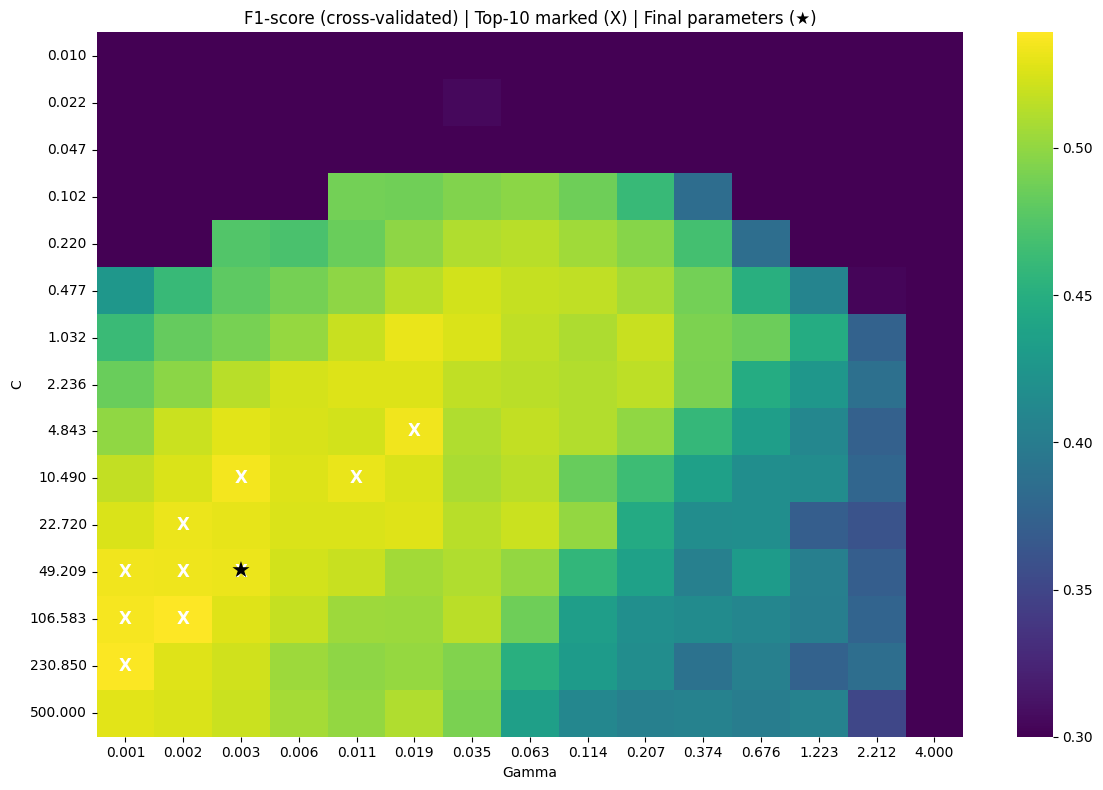

In [48]:
# Threshold for better color contrast in heatmap
threshold = 0.3
scores_matrix_clipped = np.maximum(scores_matrix, threshold)

# Plot heatmap
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    scores_matrix_clipped,
    annot=False,
    fmt=".3f",
    cmap="viridis",
    xticklabels=[f"{g:.3f}" for g in gamma_values],
    yticklabels=[f"{c:.3f}" for c in C_values]
)

#Mark top-k combinations with white X
for i, j in zip(*topk_indices_2d):
    ax.text(j + 0.5, i + 0.5, "X", ha="center", va="center", color="white", fontsize=12, fontweight="bold")

# Mark final selected point (geometric average) with black ★
best_C_idx = np.argmin(np.abs(np.array(C_values) - avg_C))
best_gamma_idx = np.argmin(np.abs(np.array(gamma_values) - avg_gamma))
ax.text(best_gamma_idx + 0.5, best_C_idx + 0.5, "★", ha="center", va="center", color="black", fontsize=16, fontweight="bold")

# Labels and axis
plt.xlabel("Gamma")
plt.ylabel("C")
plt.title(f"F1-score (cross-validated) | Top-{k} marked (X) | Final parameters (★)")
plt.tight_layout()
plt.show()

Finally, we can train the final model using all the training data and the optimal value of the hyperparameters to check the the scores on the "comparing" split.

In [49]:
# We fit the final model with the optimal values of the hyperparameters
print(f"Hiperparameters: C = {avg_C}, gamma = {avg_gamma}")

# Pre-process
scaler = StandardScaler()
X_train_scaled_st = scaler.fit_transform(X_train)
X_compare_scaled_st = scaler.transform(X_compare)

model_SVC = SVC(kernel='rbf', C=avg_C, gamma=avg_gamma, class_weight='balanced')

scores = evaluate_on_holdout(model_SVC, X_train_scaled_st, y_train, X_compare_scaled_st, y_compare)
comparing_scores.loc['SVM_best'] = scores

Hiperparameters: C = 36.12364575292815, gamma = 0.002580263158059428


In [50]:
comparing_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
QDA_smote,0.559322,0.635514,0.660131,0.458333,0.717391
GaussianNB_raw,0.576271,0.644860,0.673203,0.472222,0.739130
LDA_raw,0.289855,0.878505,0.679739,0.434783,0.217391
QDA_raw,0.530612,0.757009,0.699346,0.500000,0.565217
1NN_smote,0.375000,0.700935,0.607843,0.360000,0.391304
3NN_smote,0.388889,0.616822,0.568627,0.338710,0.456522
7NN_smote,0.442478,0.607477,0.588235,0.373134,0.543478
13NN_smote,0.363636,0.588785,0.542484,0.312500,0.434783


## Decision trees and random forests

A single decision tree is trained like this: 

In [51]:
# Define and train the model
model = DecisionTreeClassifier(
    max_depth=60,
    min_samples_split=20,
    min_samples_leaf=1,
    random_state=0
)
model.fit(X_train, y_train)


# Predict and evaluate its metrics
y_pred = model.predict(X_compare)

scores = evaluate_on_holdout(model, X_train, y_train, X_compare, y_compare)
scores["F-score"]
comparing_scores.loc['DecisionTree'] = scores

Random forest is an algorithm that trains many random decision trees and averages its predictions. A single random forest can be trained as follows: 

In [52]:
model = RandomForestClassifier(
    n_estimators=200,         # Number of decision trees
    max_depth=20,             # Depth of the trees
    random_state=0,
    class_weight='balanced'   # Important because we have unbalanced classes
)

# Fit the model and evaluate
model.fit(X_train, y_train)
y_pred = model.predict(X_compare)

scores = evaluate_on_holdout(model, X_train, y_train, X_compare, y_compare)
scores["F-score"]

0.28125

Random trees have three hyperparameters to adjust: n_estimators, max_depth and min_samples_split. We will make a grid-search to train many models with several combinations of the hyperparameters and select the best: 

In [53]:
# Hyperparameters values to try
n_estimators_list = [50, 100, 150, 200, 250, 300]
max_depth_list = [5, 10, 15, 20]
min_samples_split_list = [2, 5, 8, 10]

# Configuration of the serch-grid
param_grid = list(itertools.product(n_estimators_list, max_depth_list, min_samples_split_list))
total = len(param_grid)
results = []

# F1-Score calculator
f1_weighted = make_scorer(f1_score)

# Loop to check all combinations
for i, (n, d, m) in enumerate(param_grid):
    model = RandomForestClassifier(
        n_estimators=n,
        max_depth=d,
        min_samples_split=m,
        class_weight='balanced',
        random_state=0
    )

    # 5-fold cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_weighted)

    results.append({
        "n_estimators": n,
        "max_depth": d,
        "min_samples_split": m,
        "F1_mean": np.mean(scores),
        "F1_std": np.std(scores)
    })

    # Print progress
    percent = (i + 1) / total * 100
    print(f"[{i+1}/{total}] Progress: {percent:.1f}% - mean F1-score: {np.mean(scores):.4f}")

# Select the best result
df = pd.DataFrame(results)
best_row = df.loc[df["F1_mean"].idxmax()]

print("\nBest combination found:")
print(f"  n_estimators     = {best_row['n_estimators']}")
print(f"  max_depth        = {best_row['max_depth']}")
print(f"  min_samples_split= {best_row['min_samples_split']}")
print(f"  mean F1-score   = {best_row['F1_mean']:.4f} (± {best_row['F1_std']:.4f})")

[1/96] Progress: 1.0% - mean F1-score: 0.5218
[2/96] Progress: 2.1% - mean F1-score: 0.5265
[3/96] Progress: 3.1% - mean F1-score: 0.5227
[4/96] Progress: 4.2% - mean F1-score: 0.5335
[5/96] Progress: 5.2% - mean F1-score: 0.3214
[6/96] Progress: 6.2% - mean F1-score: 0.3611
[7/96] Progress: 7.3% - mean F1-score: 0.3944
[8/96] Progress: 8.3% - mean F1-score: 0.4194
[9/96] Progress: 9.4% - mean F1-score: 0.2368
[10/96] Progress: 10.4% - mean F1-score: 0.3011
[11/96] Progress: 11.5% - mean F1-score: 0.4015
[12/96] Progress: 12.5% - mean F1-score: 0.4096
[13/96] Progress: 13.5% - mean F1-score: 0.2136
[14/96] Progress: 14.6% - mean F1-score: 0.3008
[15/96] Progress: 15.6% - mean F1-score: 0.4062
[16/96] Progress: 16.7% - mean F1-score: 0.4096
[17/96] Progress: 17.7% - mean F1-score: 0.5278
[18/96] Progress: 18.8% - mean F1-score: 0.5122
[19/96] Progress: 19.8% - mean F1-score: 0.5262
[20/96] Progress: 20.8% - mean F1-score: 0.5346
[21/96] Progress: 21.9% - mean F1-score: 0.3172
[22/96] Pr

Finally, we obtain that the best configuration is {n_estimators = 300, max_depth = 5 and min_samples_split = 10}. We train a final model with those hyperparameters on the training set and test it on the comparison set. Finally, we can compare it with the previous ones. 

In [54]:
model_RF = RandomForestClassifier(
    n_estimators=300,  
    max_depth=5,
    min_samples_split=10,
    random_state=0,
    class_weight='balanced'
)

model_RF.fit(X_train, y_train)
y_pred = model_RF.predict(X_compare)

scores = evaluate_on_holdout(model_RF, X_train, y_train, X_compare, y_compare)
print(scores["F-score"])
comparing_scores.loc['RandomForest'] = scores

0.584070796460177


In [55]:
comparing_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
QDA_smote,0.559322,0.635514,0.660131,0.458333,0.717391
GaussianNB_raw,0.576271,0.644860,0.673203,0.472222,0.739130
LDA_raw,0.289855,0.878505,0.679739,0.434783,0.217391
QDA_raw,0.530612,0.757009,0.699346,0.500000,0.565217
1NN_smote,0.375000,0.700935,0.607843,0.360000,0.391304
3NN_smote,0.388889,0.616822,0.568627,0.338710,0.456522
7NN_smote,0.442478,0.607477,0.588235,0.373134,0.543478
13NN_smote,0.363636,0.588785,0.542484,0.312500,0.434783


Finally, we will try to train an ExtraTrees model. Again, we will perform a grid-search to select the best hyperparameters

In [56]:
# Hyperparameters grid
n_estimators_list = [50, 100, 150, 200, 250, 300]
max_depth_list = [5, 10, 15, 20]
min_samples_split_list = [2, 5, 8, 10]

param_grid = list(itertools.product(n_estimators_list, max_depth_list, min_samples_split_list))
total = len(param_grid)

results = []
f1_custom = make_scorer(f1_score)


# Loop
for i, (n, d, m) in enumerate(param_grid):
    model = ExtraTreesClassifier(
        n_estimators=n,
        max_depth=d,
        min_samples_split=m,
        random_state=0
    )

    #5-fold cross validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=f1_custom)

    results.append({
        "n_estimators": n,
        "max_depth": d,
        "min_samples_split": m,
        "F1_mean": np.mean(scores),
        "F1_std": np.std(scores)
    })

    # Progress
    percent = (i + 1) / total * 100
    print(f"[{i+1}/{total}] Progress: {percent:.1f}% - mean F1-score: {np.mean(scores):.4f}")

# Select the best result
df = pd.DataFrame(results)
best_row = df.loc[df["F1_mean"].idxmax()]

print("\n Best configuration found for ExtraTrees:")
print(f"  n_estimators     = {best_row['n_estimators']}")
print(f"  max_depth        = {best_row['max_depth']}")
print(f"  min_samples_split= {best_row['min_samples_split']}")
print(f"  mean F1-score  = {best_row['F1_mean']:.4f} (± {best_row['F1_std']:.4f})")

[1/96] Progress: 1.0% - mean F1-score: 0.0000
[2/96] Progress: 2.1% - mean F1-score: 0.0000
[3/96] Progress: 3.1% - mean F1-score: 0.0000
[4/96] Progress: 4.2% - mean F1-score: 0.0000
[5/96] Progress: 5.2% - mean F1-score: 0.1519
[6/96] Progress: 6.2% - mean F1-score: 0.1392
[7/96] Progress: 7.3% - mean F1-score: 0.0588
[8/96] Progress: 8.3% - mean F1-score: 0.0626
[9/96] Progress: 9.4% - mean F1-score: 0.3102
[10/96] Progress: 10.4% - mean F1-score: 0.2751
[11/96] Progress: 11.5% - mean F1-score: 0.1876
[12/96] Progress: 12.5% - mean F1-score: 0.1662
[13/96] Progress: 13.5% - mean F1-score: 0.3596
[14/96] Progress: 14.6% - mean F1-score: 0.3200
[15/96] Progress: 15.6% - mean F1-score: 0.2288
[16/96] Progress: 16.7% - mean F1-score: 0.1646
[17/96] Progress: 17.7% - mean F1-score: 0.0000
[18/96] Progress: 18.8% - mean F1-score: 0.0000
[19/96] Progress: 19.8% - mean F1-score: 0.0000
[20/96] Progress: 20.8% - mean F1-score: 0.0000
[21/96] Progress: 21.9% - mean F1-score: 0.1553
[22/96] Pr

We see that the F1-Score found is much worse than the Random Forest. Anyways, we will train and check the final model: 

In [57]:

model = ExtraTreesClassifier(
        n_estimators=150,
        max_depth=20,
        min_samples_split=2,
        random_state=0
    )

model.fit(X_train, y_train)
y_pred = model.predict(X_compare)

scores = evaluate_on_holdout(model, X_train, y_train, X_compare, y_compare)
print(scores["F-score"])
comparing_scores.loc['ExtraTrees'] = scores

0.4166666666666667


In [58]:
comparing_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
QDA_smote,0.559322,0.635514,0.660131,0.458333,0.717391
GaussianNB_raw,0.576271,0.644860,0.673203,0.472222,0.739130
LDA_raw,0.289855,0.878505,0.679739,0.434783,0.217391
QDA_raw,0.530612,0.757009,0.699346,0.500000,0.565217
1NN_smote,0.375000,0.700935,0.607843,0.360000,0.391304
3NN_smote,0.388889,0.616822,0.568627,0.338710,0.456522
7NN_smote,0.442478,0.607477,0.588235,0.373134,0.543478
13NN_smote,0.363636,0.588785,0.542484,0.312500,0.434783


## Ensembles

Now we can try to get the best of some models and combine them.

For example, we could try to boost a classifier with linear decision boundaries, or stack different classifiers, one of them being linear.

We will try different stacking combinations first.

In [59]:
# Pre-process
scaler = StandardScaler()
X_train_smote_scaled_st = scaler.fit_transform(X_train_smote)
X_compare_smotescaled_st = scaler.transform(X_compare)


# Stacking general model--------------

# Base learners: uncomment or comment any
base_models = [
    ('gaussian_NB', GaussianNB()),
    #('lda', LDA()),
    #('qda', QDA()),
    #('lr', LogisticRegressionCV(Cs= 20, random_state= 1, cv= 10, scoring= 'f1', solver= 'liblinear')),
    ('svm', model_SVC),
    #('RF', model_RF)
]

# Meta-learner: uncomment one of these:

#meta_model = LogisticRegressionCV()
meta_model = SVC()


# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5, n_jobs=-1)

scores = evaluate_on_holdout(stacked_model, X_train_smote_scaled_st, y_train_smote, X_compare_smotescaled_st, y_compare)
comparing_scores.loc['Stacking'] = scores



# Stacking example 1--------------

# Base learners
base_models = [
    ('lda', LDA()),
    ('lr', LogisticRegressionCV(Cs= 20, random_state= 1, cv= 10, scoring= 'f1', solver= 'liblinear')),
]

# Meta-learner
meta_model = SVC()

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

scores = evaluate_on_holdout(stacked_model, X_train_smote_scaled_st, y_train_smote, X_compare_smotescaled_st, y_compare)
comparing_scores.loc['Stacking_1'] = scores


# Stacking example 2--------------

# Base learners
base_models = [
    ('lr', LogisticRegressionCV(Cs= 20, random_state= 1, cv= 10, scoring= 'f1', solver= 'liblinear')),
    ('gaussian_NB', GaussianNB())
]

# Meta-learner
meta_model = LogisticRegressionCV()

# Stacking ensemble
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

scores = evaluate_on_holdout(stacked_model, X_train_smote_scaled_st, y_train_smote, X_compare_smotescaled_st, y_compare)
comparing_scores.loc['Stacking_2'] = scores

In [60]:
comparing_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
QDA_smote,0.559322,0.635514,0.660131,0.458333,0.717391
GaussianNB_raw,0.576271,0.644860,0.673203,0.472222,0.739130
LDA_raw,0.289855,0.878505,0.679739,0.434783,0.217391
QDA_raw,0.530612,0.757009,0.699346,0.500000,0.565217
1NN_smote,0.375000,0.700935,0.607843,0.360000,0.391304
3NN_smote,0.388889,0.616822,0.568627,0.338710,0.456522
7NN_smote,0.442478,0.607477,0.588235,0.373134,0.543478
13NN_smote,0.363636,0.588785,0.542484,0.312500,0.434783


The problem with stacking is that there are a lot of possible options. But from all the options tested, none is capable to achieve a higher F-score than LDA.

Let's try boosting. We can directly use the AdaBoost classifier. We will check different numbers of estimators.

In [61]:
adaboost_scores = pd.DataFrame(index=[], columns= ['F-score', 'Specificity', 'Accuracy', 'Precision', 'Recall'])
"""Adaboost training phase scores."""

# Pre-processing already done

for n in range(1, 50, 2):
    model_AdaBoost = AdaBoostClassifier(n_estimators=n)

    # Cross-validate and compute metrics on the training set
    scores = cross_validate_model(model_AdaBoost, X_train_smote, y_train_smote)
    adaboost_scores.loc[str(n)] = scores

In [62]:
adaboost_scores_sorted = adaboost_scores.sort_values(by="F-score", ascending=False)
adaboost_scores_sorted

,F-score,Specificity,Accuracy,Precision,Recall
43,0.747622,0.597879,0.718826,0.677873,0.839495
41,0.741622,0.602323,0.714332,0.677049,0.825859
1,0.737509,0.348384,0.656355,0.597677,0.964343
47,0.733032,0.607071,0.707690,0.673615,0.808283
49,0.730507,0.607071,0.705443,0.672497,0.803737
45,0.729041,0.624848,0.707690,0.680700,0.790101
39,0.725102,0.606768,0.700949,0.669114,0.794646
35,0.724488,0.588990,0.696504,0.661131,0.803535
33,0.724488,0.588990,0.696504,0.661131,0.803535
37,0.723566,0.602323,0.698727,0.666555,0.794646


We now should check the generalization capabilities of one of those, and it should be enough to estimate that the other will be similar. This way to select models is quite prone to overfitting, as we are trying a lot of different models and it is not enough to perform a 5.fold cross-validation.

Also, notice how 1 performs very good. This means that this AdaBoost seems basically unnecessary.

In [63]:
model_AdaBoost = AdaBoostClassifier(n_estimators=33)
scores = evaluate_on_holdout(model_AdaBoost, X_train_smote, y_train_smote, X_compare_boxcox, y_compare)
comparing_scores.loc['AdaBoost'] = scores

In [64]:
comparing_scores

,F-score,Specificity,Accuracy,Precision,Recall
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
QDA_smote,0.559322,0.635514,0.660131,0.458333,0.717391
GaussianNB_raw,0.576271,0.644860,0.673203,0.472222,0.739130
LDA_raw,0.289855,0.878505,0.679739,0.434783,0.217391
QDA_raw,0.530612,0.757009,0.699346,0.500000,0.565217
1NN_smote,0.375000,0.700935,0.607843,0.360000,0.391304
3NN_smote,0.388889,0.616822,0.568627,0.338710,0.456522
7NN_smote,0.442478,0.607477,0.588235,0.373134,0.543478
13NN_smote,0.363636,0.588785,0.542484,0.312500,0.434783


As the F-score on the comparing dataset is low, we will not try harder with AdaBoost.

Something else to check on ensembles would be bagging, but as random forests have already been tried, and the models with the highest F-score are high-bias models with linear decision boundaries, we will not try bagging.

# 5. Test prediction making

First, we will take a lot at the metrics on the "comparison" set, and select the best model we have.

In [65]:
comparing_scores_sorted = comparing_scores.sort_values(by="F-score", ascending=False)
comparing_scores_sorted

,F-score,Specificity,Accuracy,Precision,Recall
LDA_smote,0.598425,0.598131,0.666667,0.469136,0.826087
Stacking,0.589928,0.514019,0.627451,0.440860,0.891304
Stacking_2,0.588235,0.532710,0.633987,0.444444,0.869565
logreg_liblinear,0.584615,0.570093,0.647059,0.452381,0.826087
RandomForest,0.584071,0.682243,0.692810,0.492537,0.717391
Stacking_1,0.582090,0.542056,0.633987,0.443182,0.847826
SVM_best,0.579310,0.467290,0.601307,0.424242,0.913043
GaussianNB_raw,0.576271,0.644860,0.673203,0.472222,0.739130
logreg_liblinear_scaled,0.566929,0.579439,0.640523,0.444444,0.782609
GaussianNB_smote,0.560000,0.588785,0.640523,0.443038,0.760870


In the end, LDA trained on oversampled transformed data seems the best option overall.

We can train the final model using all the training data and generate the final CSV file with the predictions.

In [ ]:
X_test = pd.read_csv('test_data_ILDS.csv', header=None, names=ATTRIBUTE_NAMES)

X_boxcox = box_cox_transform(X)
X_test_boxcox = box_cox_transform(X_test)

model = LDA()
model.fit(X_boxcox, y)
y_pred = model.predict(X_test_boxcox)

submit(y_pred, "subm_lda.csv")

Predictions saved in 'submission.csv'


After seing a sudden, very hard to explain, drop to a 0.4 F-score, we will predict using the SVM. 

In [ ]:
# We fit the final model with the optimal values of the hyperparameters
print(f"Hiperparameters: C = {avg_C}, gamma = {avg_gamma}")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

model = SVC(kernel='rbf', C=avg_C, gamma=avg_gamma, class_weight='balanced')
model.fit(X_scaled, y)
y_pred = model.predict(X_test_scaled)

submit(y_pred, "subm_svm.csv")

Hiperparameters: C = 36.12364575292815, gamma = 0.002580263158059428
Predictions saved in 'subm_svm'


And with a 0.623 public testing F-score, we can choose this model as our final model.